In [2]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt


class IdealHAWT:
    """
    Class for calculating performance parameters of an ideal 3-bladed horizontal axis wind turbine
    with wake rotation and tip-loss correction.
    """

    def __init__(self, rotor_radius,cut_in=2,cut_out=20,hub_rad=0.02,rated_wind_speed=12,derate_k=0.4, air_density=1.225):
        """
        Initialize the wind turbine parameters.

        Parameters:
        -----------
        rotor_radius : float
            Rotor radius in meters
        air_density : float
            Air density in kg/m³ (default: 1.225 kg/m³ at sea level)
        """
        self.R = rotor_radius
        self.rho = air_density
        self.cut_in = cut_in
        self.cut_out = cut_out
        self.hub_rad = hub_rad
        self.bld_R = self.R*(1-self.hub_rad)
        self.A = np.pi * rotor_radius**2  # Rotor swept area
        self.rated_wind_speed = rated_wind_speed
        self.derate_k = derate_k

    def drtws(self, wind_speed):
        """
        Derate U -> D(u) = exp-D(U) 
        - rated_wind_speed: rated wind speed (m/s)
        - k: decay slope parameter (higher k -> faster decay)
        Example: D(U) = 1 for U <= rated_wind_speed, then decays smoothly.
        """
        if wind_speed <= self.rated_wind_speed:
            return wind_speed
        # smooth decay using tanh/exponential
        x = (wind_speed - self.rated_wind_speed) / max(1e-6, self.rated_wind_speed)
        # you can use exp or tanh; exp gives monotonic decay:
        return wind_speed*float(np.exp(-self.derate_k * x))
        # alternative: return max(0.0, 1.0 - k * (wind_speed - U_rated) / U_rated)

    def tsr(self, wind_speed, angular_velocity):
        """
        float : Tip speed ratio
        """
        if abs(wind_speed) < 1e-2:
            return 0

        return abs((angular_velocity * self.R) / wind_speed)

    def local_speed_ratio(self, tsr, radial_pos):
        """
        Calculate the local speed ratio at a given radial position.

        Parameters:
        -----------
        tsr : float
        radial_pos : float Radial position (0 at hub, R at tip)
        """
        return tsr * (radial_pos / self.R)

    def prandtl_tip_loss_factor(self, radial_pos, a, tsr,hub_factor=1):
        """
        Calculate Prandtl tip loss correction factor for 3 blades.

        Parameters:
        -----------
        radial_pos : float
            Radial position
        a : float
            Axial induction factor
        tsr : float
            Tip speed ratio

        Returns:
        --------
        float : Tip loss factor F
        """
        if radial_pos >= self.R:
            return 0.0

        # Local speed ratio at current radial position
        lambda_r = self.local_speed_ratio(tsr, radial_pos)

        # Avoid division by zero
        if lambda_r == 0 or radial_pos == 0:
            return 0.0

        # Calculate flow angle phi
        # phi = np.arctan(1 / ((1 - a) * lambda_r))
        # Calculate flow angle phi
        phi = np.arctan((1 - a) * (4 * a - 1) / (a * lambda_r))

        # Calculate the argument for the exponential - tip loss
        f_tip = (3 / 2) * ((self.R - radial_pos) / (radial_pos * np.sin(phi)))
        exp_tip = np.exp(-np.clip(f_tip, -100, 100))
        F_tip = (2 / np.pi) * np.arccos(np.clip(exp_tip, -1.0, 1.0))

        # Hub loss factor
        hub_radius = self.hub_rad * self.R  # Start of the blade = end of hub
        if radial_pos <= hub_radius:
            F_hub = 0.0
        else:
            f_hub = (3 / 2) * ((radial_pos - hub_radius) / (radial_pos * np.sin(phi)))
            exp_hub = np.exp(-np.clip(f_hub, -100, 100))
            F_hub = (2 / np.pi) * np.arccos(np.clip(exp_hub, -1.0, 1.0))

        return F_tip * (F_hub)**hub_factor

    def axial_induction_from_lambda_r(self, lambda_r):
        """
        Calculate axial induction factor for maximum power at given local speed ratio.

        Parameters:
        -----------
        lambda_r : float
            Local speed ratio
        radial_pos : float
            Radial position for tip loss calculation

        Returns:
        --------
        float : Axial induction factor a
        """
        if lambda_r == 0:
            return 0.25

        # Define the equation to solve
        def equation(a):
            return (1 - a) * (4 * a - 1) ** 2 - lambda_r**2 * (1 - 3 * a)

        # Solve for a in the range [0.25, 0.333]
        a_initial = 0.3
        try:
            a_solution = fsolve(equation, a_initial)[0]
            a_solution = np.clip(a_solution, 0.1, 1 / 3)
        except:
            a_solution = 1 / 3

        # Apply tip loss factor (always applied)
        # F = self.prandtl_tip_loss_factor(radial_pos, a_solution, tsr)

        # For modern turbines operating at optimal TSR (7-10), axial induction stays around 0.33
        # No Glauert correction needed as a < 0.4 for optimal operation
        # inside loop, after computing a
        # a_eff = a * (1.0 - np.exp(-self.gamma * (wind_speed - U_rated))) if wind_speed > U_rated else a
        # U_eff = wind_speed * (1.0 - a_eff)
        # use U_eff in dT/dQ calculation instead of wind_speed

        return np.clip(a_solution, 0.0, 0.5)

    def angular_induction_factor(self, a, radial_pos, tsr):
        """
        Calculate angular induction factor from axial induction factor.

        Parameters:
        -----------
        a : float
            Axial induction factor a
        radial_pos : float
            Radial position for tip loss calculation
        tsr : float
            Tip speed ratio for tip loss calculation

        Returns:
        --------
        float : Angular induction factor a'
        """
        if a <= 0.25 or abs(4 * a - 1) < 1e-10:
            return 0.0

        # a_prime = (1 - 3 * a) / (4 * a - 1)
        local_tsr = self.local_speed_ratio(tsr, radial_pos)
        a_prime = -0.5 + 0.5 * np.sqrt(1 + 4 * a * (1 - a) / (local_tsr**2))
        # # Apply tip loss correction to angular induction factor (always applied)
        # F = self.prandtl_tip_loss_factor(radial_pos, axial_induction, tsr)
        # if F > 1e-10:  # Avoid division by zero
        #     a_prime = a_prime / F

        return max(a_prime, 0.0)

    def power_coefficient(self, wind_speed, angular_velocity, n_points=100):
        """
        Calculate the power coefficient by integrating over the rotor.

        Parameters:
        -----------
        tsr : float
            Tip speed ratio
        n_points : int
            Number of integration points

        Returns:
        --------
        float : Power coefficient C_P
        """
        tsr = self.tsr(wind_speed, angular_velocity)
    
        if wind_speed < 2.5:
            return 0
        
        if tsr <= 1:
            return 0.05 * tsr

        radial_pos = np.linspace(self.hub_rad * self.R, self.R, n_points)
        d_lambda_r = tsr / n_points

        integral = 0.0

        for r in radial_pos:
            lambda_r = self.local_speed_ratio(tsr, r)

            if lambda_r <= 0:
                continue

            a = self.axial_induction_from_lambda_r(lambda_r)
            a_prime = self.angular_induction_factor(a, r, tsr)

            # Get tip loss factor (always applied)
            F = self.prandtl_tip_loss_factor(r, a, tsr)

            integral += F * a_prime * (1 - a) * lambda_r**3 * d_lambda_r

        cp = (8 / tsr**2) * integral
        return min(cp, 0.5926)

    def annular_torque(self, wind_speed, angular_velocity, radial_pos, dr):
        """
        Calculate torque on an annular element at radius r with thickness dr.

        Parameters:
        -----------
        wind_speed : float
            Free stream wind speed in m/s
        angular_velocity : float
            Rotor angular velocity in rad/s
        radial_pos : float
            Radial position of the annular element
        dr : float
            Thickness of the annular element

        Returns:
        --------
        float : Torque on annular element in N·m
        """
        lambda_tsr = self.tsr(wind_speed, angular_velocity)
        lambda_r = self.local_speed_ratio(lambda_tsr, radial_pos)

        a = self.axial_induction_from_lambda_r(lambda_r)
        a_prime = self.angular_induction_factor(a, radial_pos, lambda_tsr)

        # Calculate tip loss factor (always applied)
        F = self.prandtl_tip_loss_factor(radial_pos, a, lambda_tsr)

        # Calculate annular area and torque
        dA = 2 * np.pi * radial_pos * dr
        Cq = 4 * F * a_prime * (1 - a)
        dQ = 0.5 * Cq * self.rho * self.drtws(wind_speed) * angular_velocity * radial_pos**2 * dA
        return dQ

    def total_torque(self, wind_speed, angular_velocity, n_annuli=100):
        """
        Calculate total torque on the rotor by integrating annular torques.

        Parameters:
        -----------
        wind_speed : float
            Free stream wind speed in m/s
        angular_velocity : float
            Rotor angular velocity in rad/s
        n_annuli : int
            Number of annular elements for integration

        Returns:
        --------
        float : Total torque in N·m
        """
        dr = self.bld_R / n_annuli
        total_torque = 0.0

        if wind_speed < 0:
            return total_torque
        elif wind_speed < 2.5:
            Cq = 0.04
            total_torque = 0.5 * Cq * self.rho * self.R * self.A * wind_speed**2

        for i in range(n_annuli):
            r = (i + 0.5) * dr
            if r < self.hub_rad * self.R:  # Skip very small radii near hub
                continue
            dQ = self.annular_torque(self.drtws(wind_speed), angular_velocity, r, dr)
            if np.isfinite(dQ):  # Only add finite values
                total_torque += dQ

        return total_torque

    def thrust_coefficient(self, wind_speed, angular_velocity, n_points=100):
        den = 0.5 * self.rho * self.A * (wind_speed) ** 2
        return self.total_thrust(wind_speed, angular_velocity, n_points) / den

    def total_thrust(self, wind_speed, angular_velocity, n_points=100):
        """
        Parameters:
        -----------
        tsr : float
            Tip speed ratio
        n_points : int
            Number of integration points

        Returns:
        --------
        float : Total Thrust [N]
        """

        tsr = self.tsr(wind_speed, angular_velocity)
        thrust = 0.0

        if wind_speed < 0:
            return thrust
        elif wind_speed < 2.5:
            Ct_parked = 0.18
            thrust = 0.5 * Ct_parked * self.rho * self.A * (wind_speed) ** 2
            return thrust
            # print(thrust)
        radial_poss = np.linspace(self.hub_rad * self.R, self.R, n_points)
        dr = self.bld_R / n_points

        for r in radial_poss:
            dA = 2 * np.pi * r * dr
            lambda_r = self.local_speed_ratio(tsr, r)

            if lambda_r <= 0:
                continue

            a = self.axial_induction_from_lambda_r(lambda_r)
            F = self.prandtl_tip_loss_factor(r, a, tsr)
            Ct = 4.0 * a * (1.0 - a)

            # print(f"r:{r:.3f} - a:{a:.3f} - F:{F:.3F} - Ct:{Ct:.3f}")
            # Annular thrust - using standard momentum theory (no Glauert correction)
            # For optimal TSR operation, a < 0.4 so C_T = 4a(1-a) is valid
            dT = 0.5 * Ct * F * self.rho * self.drtws((wind_speed)) ** 2 * dA

            if np.isfinite(dT):
                thrust += dT

        return thrust

    def power_output(self, wind_speed, angular_velocity, mechanical_efficiency=0.95):
        """
        Calculate mechanical power output.

        Parameters:
        -----------
        wind_speed : float
            Free stream wind speed in m/s
        angular_velocity : float
            Rotor angular velocity in rad/s
        mechanical_efficiency : float
            Mechanical/electrical efficiency (default: 0.95)

        Returns:
        --------
        float : Power output in Watts
        """
        cp = self.power_coefficient(wind_speed, angular_velocity)
        if not np.isfinite(cp):
            cp = 0.0
        power_wind = 0.5 * self.rho * self.A * wind_speed**3
        return mechanical_efficiency * cp * power_wind


def calculate_torque(rotor_radius, wind_speed, angular_velocity):
    """
    Simple function to calculate torque for given conditions.

    Parameters:
    -----------
    rotor_radius : float
        Rotor radius in meters
    wind_speed : float
        Wind speed in m/s
    angular_velocity : float
        Angular velocity in rad/s

    Returns:
    --------
    float : Torque in N·m
    """
    turbine = IdealHAWT(rotor_radius)
    torque = turbine.total_torque(wind_speed, angular_velocity)
    return torque if np.isfinite(torque) else 0.0


def calculate_thrust(rotor_radius, wind_speed, angular_velocity):
    """
    Simple function to calculate thrust for given conditions.
    float : thrust in N
    """
    turbine = IdealHAWT(rotor_radius)
    thrust = turbine.total_thrust(wind_speed, angular_velocity)
    return thrust if np.isfinite(thrust) else 0.0


def calculate_power_coefficient(rotor_radius, wind_speed, angular_velocity):
    """
    Simple function to calculate power coefficient.

    Parameters:
    -----------
    rotor_radius : float
        Rotor radius in meters
    tsr : float
        Tip speed ratio

    Returns:
    --------
    float : Power coefficient C_P
    """
    turbine = IdealHAWT(rotor_radius)
    cp = turbine.power_coefficient(wind_speed, angular_velocity)
    return cp if np.isfinite(cp) else 0.0


def plot_tip_loss_distribution(tsr=7.5):
    """
    Plot tip loss factor distribution across the rotor
    """
    turbine = IdealHAWT(rotor_radius=1.0)

    radial_pos = np.linspace(0, 1.0, 100)
    tip_loss_factors = []

    for r in radial_pos:
        # Calculate tip loss factor for a typical axial induction
        F = turbine.prandtl_tip_loss_factor(r, 1 / 3, tsr)
        tip_loss_factors.append(F)

    plt.figure(figsize=(10, 6))
    plt.plot(radial_pos, tip_loss_factors, "b-", linewidth=2)
    plt.xlabel("Normalized Radial Position (r/R)")
    plt.ylabel("Tip Loss Factor, F")
    plt.title(f"Prandtl Tip Loss Factor Distribution (λ = {tsr})")
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1.1)
    plt.show()


def plot_power_coefficient_vs_tsr(omega = 1):
    """
    Plot power coefficient vs tip speed ratio
    """
    turbine = IdealHAWT(rotor_radius=1.0)
    wind_speed = np.linspace(0.1, 20, 600)
    tsr_values = [turbine.tsr(ws,omega) for ws in wind_speed]
    cp_values = [turbine.power_coefficient(ws,omega) for ws in wind_speed]
    
    plt.figure(figsize=(10, 6))
    plt.plot(tsr_values, cp_values, "b-", linewidth=2, label="With Tip Loss Correction")
    plt.axhline(y=16 / 27, color="r", linestyle="--", linewidth=2, label="Betz Limit")
    plt.xlabel("Tip Speed Ratio, λ")
    plt.ylabel("Power Coefficient, C_P")
    plt.title("Power Coefficient vs Tip Speed Ratio for 3-Bladed Turbine - Omega = 1rad/s")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.ylim(0, 0.65)
    plt.show()

def plot_a_vs_tsr(tsr = 7.5):
    """
    Plot power coefficient vs tip speed ratio
    """
    turbine = IdealHAWT(rotor_radius=1.0)
    rr = np.linspace(0, 1, 100)
    lambda_r = [turbine.local_speed_ratio(tsr,r) for r in rr]
    a = [turbine.axial_induction_from_lambda_r(l) for l in lambda_r]
    plt.figure(figsize=(10, 6))
    plt.plot(rr, a, "b-", linewidth=2, label="With Wake Effect")
    plt.axhline(y=1 / 3, color="r", linestyle="--", linewidth=2, label="Optimum")
    plt.ylabel("Axial induction, a")
    plt.xlabel("radial position, r/R")
    plt.title(f"a vs r/R  - λ = {tsr}")
    plt.grid(True, alpha=0.3)
    plt.legend()
    # plt.ylim(0, 0.65)
    plt.show()


def main():
    """
    Demonstration of the 3-bladed wind turbine analysis.
    """
    # Initialize turbine
    turbine = IdealHAWT(rotor_radius=50.0)

    print("3-BLADED WIND TURBINE ANALYSIS")
    print("=" * 50)

    # Example calculations
    wind_speed = 12.0
    angular_velocity = 1.8

    # Calculate performance metrics
    tsr = turbine.tsr(wind_speed, angular_velocity)
    cp = turbine.power_coefficient(wind_speed, angular_velocity)
    ct = turbine.thrust_coefficient(wind_speed, angular_velocity)
    torque = turbine.total_torque(wind_speed, angular_velocity)
    power = turbine.power_output(wind_speed, angular_velocity)

    print(f"Rotor radius: {turbine.R} m")
    print(f"Wind speed: {wind_speed} m/s")
    print(f"Angular velocity: {angular_velocity} rad/s")
    print(f"Tip speed ratio: {tsr:.3f}")
    print(f"Power coefficient C_P: {cp:.4f}")
    print(f"Thrust coefficient C_T: {ct:.4f}")
    print(f"Torque: {torque:,.0f} N·m")
    print(f"Power output: {power/1e6:.2f} MW")
    print(f"Available wind power: {0.5*turbine.rho*turbine.A*wind_speed**3/1e6:.2f} MW")

    print("\n" + "=" * 50)
    print("TORQUE CALCULATIONS FOR DIFFERENT CONDITIONS")
    print("=" * 50)

    # Torque for different conditions
    wind_speeds = [2, 5, 8, 10, 12, 15]
    angular_velocities = [0.1, 0.5, 1, 1.2, 1.5]

    print(
        f"{'Wind Speed':<12} {'Angular Velocity':<18} {'TSR':<8} {'Torque':<10} {'Thrust':<10} {'Ct':<8}"
    )
    print(f"{'(m/s)':<12} {'(rad/s)':<18} {'':<8} {'(kN·m)':<10} {'(kN·m)':<10} {'  -  ':<8}")
    print("-" * 65)

    for av in angular_velocities:
        for ws in wind_speeds:
            torque_val = calculate_torque(50.0, ws, av) / 1000
            thrust_val = calculate_thrust(50.0, ws, av) / 1000
            tsr_val = turbine.tsr(ws, av)
            ct = turbine.thrust_coefficient(ws, av)
            print(
                f"{ws:<12.1f} {av:<18.1f} {tsr_val:<8.2f} {torque_val:<12.1f} {thrust_val:<12.1f} {ct:<8.3f}"
            )

    # Create plots
    print("\nGenerating plots...")
    plot_tip_loss_distribution()
    plot_power_coefficient_vs_tsr()

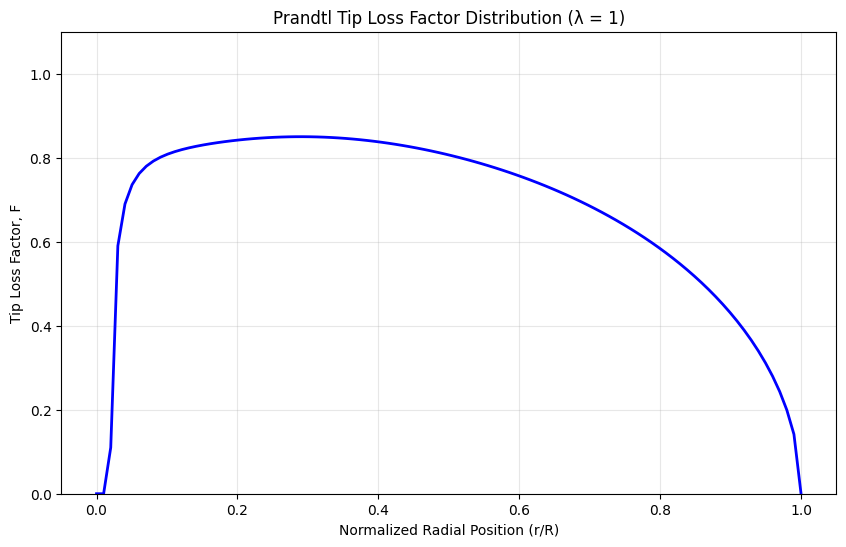

In [3]:
plot_tip_loss_distribution(1)

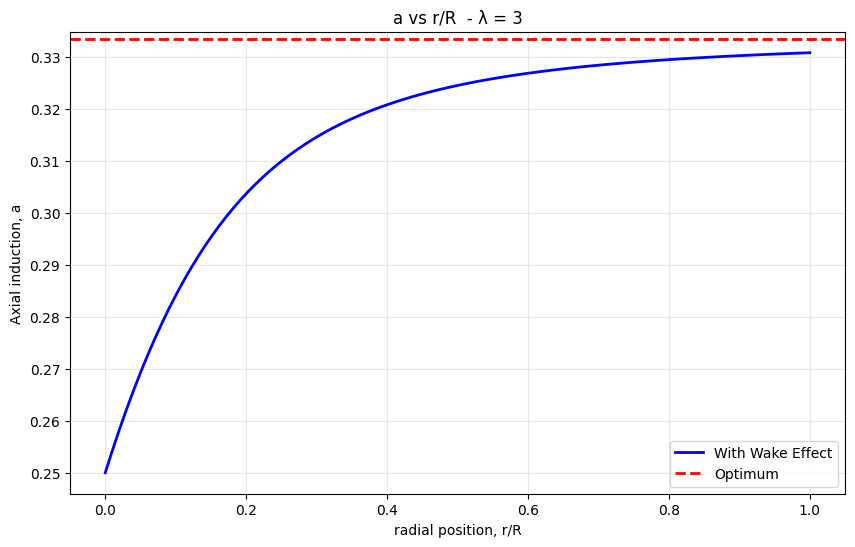

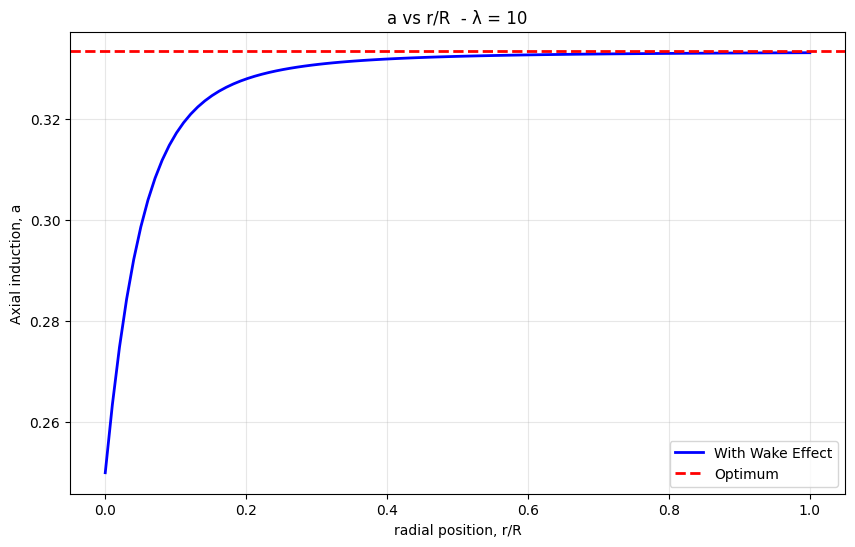

In [4]:
plot_a_vs_tsr(3)
plot_a_vs_tsr(10)

In [5]:
turbine = IdealHAWT(64,hub_rad=0.02)
turbine.total_thrust(10,1,n_points=100)

np.float64(624998.0497217387)

In [6]:
import pandas as pd

def fast_out_to_df(filename):
    with open(filename) as fid:
        headers = [fid.readline() for _ in range(6)]  # Read header
        channels = fid.readline().strip().split()  # Channel names
        units = fid.readline().strip().split()  # Channel units
        data = np.loadtxt(filename, skiprows=8)  # time series
        return pd.DataFrame(data=data, columns=channels)

# dforce = pd.read_csv(f"./fast_force_5.tsv", sep=r"\s+")
dfwind = pd.read_csv(f"./wind_sdrei_augmented.tsv", sep=r"\s+")
# df1 = pd.read_csv('FEM_SSM_out_fast_force_5.csv')
# dfw5 = fast_out_to_df("/home/lorenzo/Desktop/feuphd/openfast_5mw_francisco/5MW_W0500_T1000_S01.out")
# dfw10 = fast_out_to_df("/home/lorenzo/Desktop/feuphd/openfast_5mw_francisco/5MW_W1000_T1000_S01.out")
# dfw15 = fast_out_to_df("/home/lorenzo/Desktop/feuphd/openfast_5mw_francisco/5MW_W1500_T1000_S01.out")

In [7]:
rated_wind = 11.4
cutin_wind = 4
omega_max = 1.267

In [8]:
def omega_from_w(ws):
    if ws>=rated_wind:
        return omega_max
    elif ws < cutin_wind:
        return 0
    return ws*omega_max/rated_wind

In [9]:
dfwind['omega'] = dfwind['WindVelX'].apply(omega_from_w)

In [ ]:
turbine = IdealHAWT(64)

Ct = [turbine.thrust_coefficient(ws,omega) for ws,omega in zip(dfwind['WindVelX'],dfwind['omega'])]
Cp = [turbine.power_coefficient(ws,omega) for ws,omega in zip(dfwind['WindVelX'],dfwind['omega'])]

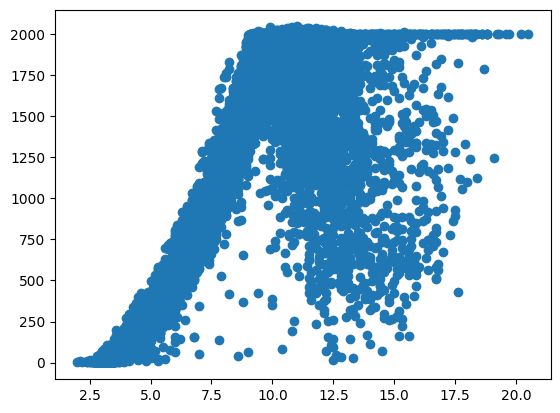

In [10]:
dfs = pd.read_csv('/home/lorenzo/Desktop/feuphd/server_data_ishm/sdrei_2022scada.csv')
dfs = dfs[dfs['avg_power_output']>1]
dfs = dfs[dfs['avg_wind_speed']>0.1]

plt.scatter(dfs['avg_wind_speed'],dfs['avg_power_output'])

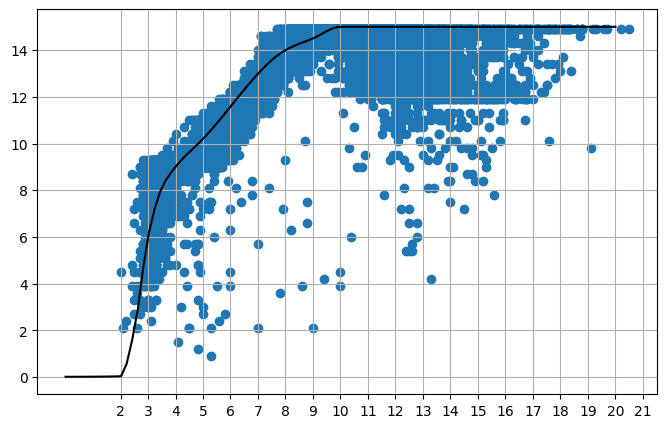

In [13]:
from scipy.interpolate import PchipInterpolator

inter = np.array([
        [0,0.01],
        [2,0.03],
        [2.5,2],
        [3,6],
        [3.5,8.1],
        [4,9],
        [5,10.2],
        [8,14],
        [9,14.5],
        [10,15],
        [14,15],
        [19,15],
         ]).T

rmpfromws = PchipInterpolator(inter[0,:],inter[1,:],extrapolate=True)

plt.figure(figsize=(8,5))
plt.scatter(dfs['avg_wind_speed'],dfs['avg_rotor_speed'])
plt.xticks(np.arange(dfs['avg_wind_speed'].min(), dfs['avg_wind_speed'].max() + 1, 1))
# plt.plot(inter[0,:],inter[1,:],'k')
wss = np.linspace(0,20,100)
plt.plot(wss,rmpfromws(wss),'k')
plt.grid()

In [176]:
rpmtorads = 0.10471975511965977 #2*np.pi/60
def ws2omega(ws,cutin=2.5,cutout=20):
    # if ws<cutin or ws>cutout:
    if ws<cutin:
        return 0
    return rpmtorads*rmpfromws(ws)

In [194]:
turbine = IdealHAWT(64,hub_rad=0.02,rated_wind_speed=11)


ws = np.linspace(0.1,25,100)
Ct_op = [turbine.thrust_coefficient(w,ws2omega(w)) for w in ws]
Cp_op = [turbine.power_coefficient(w,ws2omega(w)) for w in ws]

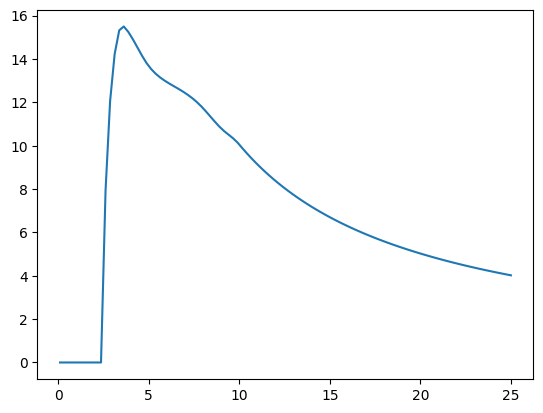

In [195]:
plt.plot(ws,[turbine.tsr(w,ws2omega(w)) for w in ws])

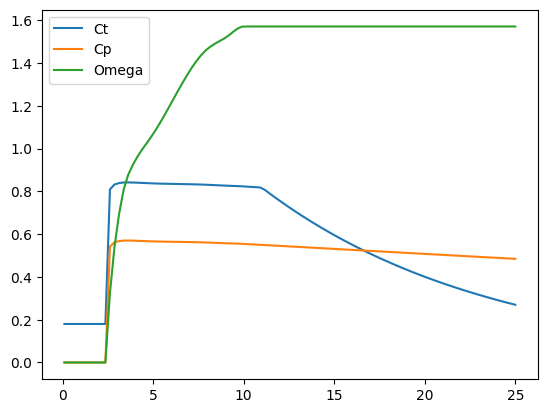

In [196]:
plt.plot(ws,Ct_op, label='Ct')
plt.plot(ws,Cp_op, label='Cp')
plt.plot(ws,[ws2omega(w) for w in ws], label='Omega')
plt.legend()
# plt.ylim((0,1))

In [63]:
np.sum(dfs['avg_power_output']<100)

np.int64(5519)

/tmp/ipykernel_1435429/4151361987.py:79: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('v_bin').agg({


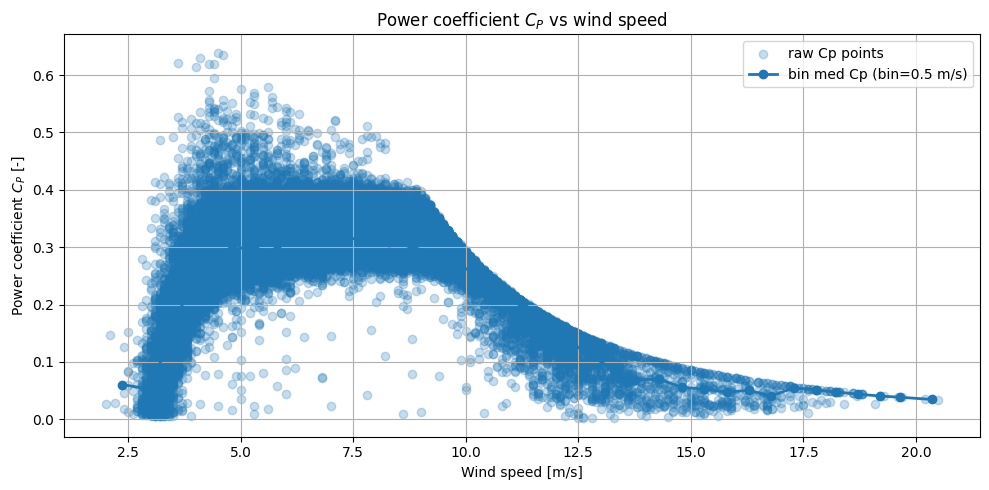

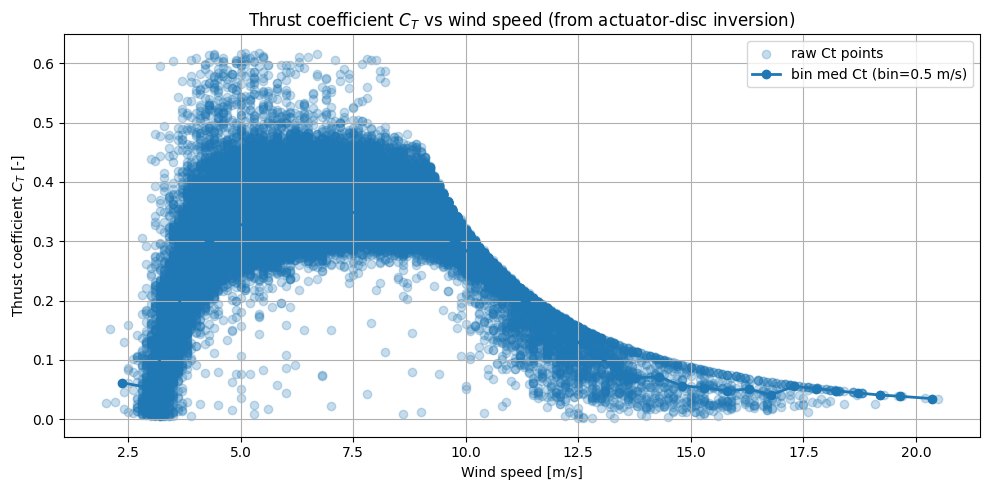

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- USER: check these (edit if needed) ---
rho = 1.225       # air density [kg/m^3]
R = 63.0          # rotor radius [m]
A = np.pi * R**2  # rotor swept area [m^2]
# If your power is in kW set power_in_kw = True
power_in_kw = False

# --- df: your dataframe (replace this with your actual df variable) ---
df = dfs.copy()   # using the name you gave in the conversation

# Convert power to Watts if needed
df['power_W'] = df['avg_power_output'] * 1000.0/0.9

# --- compute Cp safely ---
# avoid division by zero
df['ws'] = df['avg_wind_speed'].replace(0, np.nan)
df['Cp'] = df['power_W'] / (0.5 * rho * A * df['ws']**3)

# Clip unrealistic Cp values (momentum theory max CP = 16/27 ≈ 0.5926)
CP_MAX = 16.0/27.0
df.loc[df['Cp'] > 2*CP_MAX, 'Cp'] = np.nan  # a very conservative cut
# warn if Cp above theoretical limit
if (df['Cp'] > CP_MAX).any():
    print("Warning: some Cp values exceed the Betz limit (16/27 ≈ 0.5926). They will be handled but check units/measurements.")

# --- function: invert Cp -> a using bisection (robust) ---
def solve_a_from_cp(cp_val, tol=1e-6, maxiter=60):
    """
    Solve CP = 4 a (1-a)^2 for a in [0, 0.5).
    Returns np.nan if no valid root in [0,0.499999].
    """
    if np.isnan(cp_val):
        return np.nan
    # CP function
    def f(a): return 4*a*(1-a)**2 - cp_val

    # CP range: at a=0 -> 0; at a=1/3 -> CP_max ≈ 0.5926; after that decreases but a>0.5 not physical
    a_low, a_high = 0.0, 0.499999
    f_low, f_high = f(a_low), f(a_high)
    # If cp_val is negative or too large, no solution in [0,0.5)
    if f_low == 0:
        return a_low
    if f_low * f_high > 0:
        # no sign change -> out of range
        return np.nan

    # bisection
    for _ in range(maxiter):
        a_mid = 0.5*(a_low + a_high)
        f_mid = f(a_mid)
        if abs(f_mid) < tol:
            return a_mid
        if f_low * f_mid <= 0:
            a_high = a_mid
            f_high = f_mid
        else:
            a_low = a_mid
            f_low = f_mid
    return 0.5*(a_low + a_high)

# apply vectorized
df['a'] = np.array([solve_a_from_cp(cpv) for cpv in df['Cp']])
# compute Ct from a
df['Ct'] = 4 * df['a'] * (1 - df['a'])

# tidy invalid values
df = df.replace([np.inf, -np.inf], np.nan)

# --- Optional: bin average by wind speed for smoother plots ---
bin_width = 0.5  # m/s, change if you want coarser/finer smoothing
vmin = np.nanmin(df['ws'])
vmax = np.nanmax(df['ws'])
bins = np.arange(np.floor(vmin), np.ceil(vmax) + bin_width, bin_width)
df['v_bin'] = pd.cut(df['ws'], bins, include_lowest=True)
grouped = df.groupby('v_bin').agg({
    'ws': 'mean',
    'Cp': 'median',
    'Ct': 'median',
    'power_W': 'count'
}).rename(columns={'power_W': 'count'}).dropna(subset=['ws'])

# --- PLOTTING ---
plt.figure(figsize=(10,5))
plt.scatter(df['ws'], df['Cp'], alpha=0.25, label='raw Cp points')
plt.plot(grouped['ws'], grouped['Cp'], marker='o', linewidth=2, label=f'bin med Cp (bin={bin_width} m/s)')
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Power coefficient $C_P$ [-]')
plt.title('Power coefficient $C_P$ vs wind speed')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(df['ws'], df['Ct'], alpha=0.25, label='raw Ct points')
plt.plot(grouped['ws'], grouped['Ct'], marker='o', linewidth=2, label=f'bin med Ct (bin={bin_width} m/s)')
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Thrust coefficient $C_T$ [-]')
plt.title('Thrust coefficient $C_T$ vs wind speed (from actuator-disc inversion)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


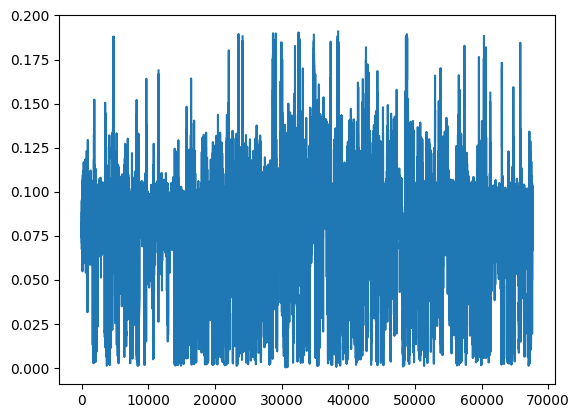

In [70]:
plt.plot(df['a'])